In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import subprocess
import spacy
import random
import os
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from gensim.models import KeyedVectors
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
from nltk.stem import SnowballStemmer
from spacy.cli import download


In [2]:
data = pd.read_excel('/Users/rachael/Downloads/train_df_labelled copy.xlsx')
sentiment = data[['content','sentiment_A','sentiment_B']]
sentiment.head()

,content,sentiment_A,sentiment_B
0,Om het nog bondiger te zeggen: ik stemde ooit ...,Negative,Negative
1,Volgens de peilingen stond PVV 2 weken geleden...,Negative,Negative
2,PVV stemmers mogen dan het geheugen hebben van...,Negative,Negative
3,"PVV wil geen vluchtelingen, Omtzigt wil geen e...",Neither,Negative
4,Dat weten we niet. PVV heeft veel strategische...,Neither,Neither


In [245]:
# different_sentiment = sentiment[sentiment['sentiment_A'] != sentiment['sentiment_B']]
# disagreement_counts = different_sentiment.groupby(['sentiment_A', 'sentiment_B']).size().sort_values(ascending=False).reset_index(name='count')
# disagreement_counts 

,sentiment_A,sentiment_B,count
0,Negative,Neither,28
1,Neither,Negative,14
2,Positive,Negative,9
3,Positive,Neither,9
4,Negative,Positive,6


In [3]:
label_sentiment_A = sentiment['sentiment_A'].value_counts()
label_sentiment_B = sentiment['sentiment_B'].value_counts()
label_proportions_sentiment_A = sentiment['sentiment_A'].value_counts(normalize=True)
label_proportions_sentiment_B = sentiment['sentiment_B'].value_counts(normalize=True)
# Printing the results
print("Counts of each label_sentiment_A:")
print(label_sentiment_A)
print("Counts of each label_sentiment_B:")
print(label_sentiment_B)
print()
print("\nProportions of each label_sentiment_A:")
print(label_proportions_sentiment_A)
print("\nProportions of each label_sentiment_B:")
print(label_proportions_sentiment_B)

Counts of each label_sentiment_A:
sentiment_A
Negative    283
Neither      74
Positive     52
Name: count, dtype: int64
Counts of each label_sentiment_B:
sentiment_B
Negative    272
Neither      97
Positive     40
Name: count, dtype: int64


Proportions of each label_sentiment_A:
sentiment_A
Negative    0.691932
Neither     0.180929
Positive    0.127139
Name: proportion, dtype: float64

Proportions of each label_sentiment_B:
sentiment_B
Negative    0.665037
Neither     0.237164
Positive    0.097800
Name: proportion, dtype: float64


In [3]:
from sklearn.metrics import cohen_kappa_score
# Assuming test_rater1_labels and test_rater2_labels are the labels from the two raters for the test set
data1 = pd.read_excel('/Users/rachael/Downloads/train_df_labelled copy 2.xlsx')
sentiment1 = data1[['content','sentiment_A','sentiment_B']]
kappa_sentiment_train = cohen_kappa_score(sentiment1['sentiment_A'], sentiment1['sentiment_B'])
print("Cohen's kappa of sentiment for the train set: ", kappa_sentiment_train)

Cohen's kappa of sentiment for the train set:  0.5134130822092136


In [4]:
#Assuming test_rater1_labels and test_rater2_labels are the labels from the two raters for the test set
stance = data1[['content','stance_A','stance_B']]
kappa_stance_train = cohen_kappa_score(stance['stance_A'], stance['stance_B'])
print("Cohen's kappa of sentiment for the train set: ", kappa_stance_train)

Cohen's kappa of sentiment for the train set:  0.5828545162031716


In [3]:
#the data verified by the third person will be used as the train set finally
file =  data[['content','sentiment']]
file['sentiment'].value_counts()
label_sentiment= file['sentiment'].value_counts()
label_proportions_sentiment= file['sentiment'].value_counts(normalize=True)
print("Counts of each label_sentiment:")
print(label_sentiment)
print("\nProportions of each label_sentiment:")
print(label_proportions_sentiment)

Counts of each label_sentiment:
sentiment
Negative    262
Neither      99
Positive     48
Name: count, dtype: int64

Proportions of each label_sentiment:
sentiment
Negative    0.640587
Neither     0.242054
Positive    0.117359
Name: proportion, dtype: float64


In [4]:
def remove_urls(text):
    # 定义URL的正则表达式
    url_pattern = r'https?://\S+|www\.\S+'
    # 使用re.sub()函数替换URL为空字符串
    no_url_text = re.sub(url_pattern, '', text)
    return no_url_text

def clean_text(text):
    # Remove anything that is not a letter or space
    clean_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lower case
    clean_text = clean_text.lower()
    return clean_text

In [8]:
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
#convert categorical to numerical 
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
y = file['sentiment']
X = file['content']

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_7542/2325409604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(remove_urls)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_7542/2325409604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(clean_text)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_7542/2325409604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [7]:
# # Apply functions to clean the content column
# file.loc[:, 'content'] = file['content'].apply(remove_urls)
# file.loc[:, 'content'] = file['content'].apply(clean_text)

# # Convert categorical sentiment to numerical
# file.loc[:, 'sentiment'] = file['sentiment'].replace({'Positive': 0, 'Negative': 1, 'Neither': 2})

# # Extract features and labels
# y = file['sentiment']
# X = file['content']

In [16]:
type(file['sentiment'])

pandas.core.series.Series

In [185]:

download("nl_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:


model_path = '/Users/rachael/Downloads/39/model.bin'

# Attempt to load the model assuming it's in word2vec format
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)
vector_size = word_vectors.vector_size #100
nlp = spacy.load("nl_core_news_sm")

#tokenize
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

# calculate the average woord vectors as sentences feature
def sentence_to_avg_vec(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for token in tokens:
        if token in model:
            vec += model[token]
            count += 1
    if count != 0:
        vec /= count
    return vec

In [193]:
#map pre-trained word2vec embeddings to my own data
# 获取每个词的 Word2Vec 嵌入
# def get_word2vec_embeddings(tokens):
#     embeddings = []
#     for token in tokens:
#         if token in word_vectors:
#             embeddings.append(word_vectors[token])
#         else:
#             # 如果词不在词汇表中，可以使用随机初始化或零向量
#             embeddings.append(np.zeros(word_vectors.vector_size))
#     return embeddings

In [7]:
#hyperparameter range
param_dist= {
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

best_score = 0
best_params = {}
test_scores = []
best_params_list = []
f1_scores = []

In [28]:
# Stratified K-fold for maintaining label distribution,shuffle=True确保每次迭代的数据划分不同
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop over each fold
for train_index, test_index in outer_cv.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]

    # convert y_train and y_test to DataFrame
    y_train_df = pd.DataFrame(trainy).reset_index(drop=True)
    y_test_df = pd.DataFrame(testy).reset_index(drop=True)

    # concat X_train and y_train, X_test and y_test
    train_df = pd.concat([trainX.reset_index(drop=True), y_train_df], axis=1)
    test_df = pd.concat([testX.reset_index(drop=True), y_test_df], axis=1)
    
    #process data to the format that is acceptable by data augmentation technique
    train_df['content'] = train_df['content'].apply(lambda x: ' '.join(x.split()))
    sentiment_0 = train_df[train_df['sentiment'] == 0]
    sentiment_1 = train_df[train_df['sentiment'] == 1]
    sentiment_2 = train_df[train_df['sentiment'] == 2]

    #expand class0,save file as temporary files
    output_file_path0 = '/Users/rachael/Desktop/data/sentiment_0.txt'
    #convert DataFrame data into a simple tab-separated text file format，required by the data augmentation technique
    with open(output_file_path0, 'w', encoding='utf-8') as f:
        for _, row in sentiment_0.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")
    subprocess.run([
    'python', '/Users/rachael/Desktop/data/augment.py',
    '--input', output_file_path0,
    '--output', '/Users/rachael/Desktop/data/augmented_train0.txt', 
    '--num_aug', '9',
    '--alpha_sr', '0.1',
    '--alpha_rd', '0.1',
    '--alpha_ri', '0.1',
    '--alpha_rs', '0.1'
])

    #expand class1,save file as temporary files
    output_file_path1 = '/Users/rachael/Desktop/data/sentiment_1.txt'
    with open(output_file_path1, 'w', encoding='utf-8') as f:
        for _, row in sentiment_1.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")  
    subprocess.run([
    'python', '/Users/rachael/Desktop/data/augment.py',
    '--input', output_file_path1,
    '--output', '/Users/rachael/Desktop/data/augmented_train1.txt', 
    '--num_aug', '1',
    '--alpha_sr', '0.1',
    '--alpha_rd', '0.1',
    '--alpha_ri', '0.1',
    '--alpha_rs', '0.1'
])
    
    output_file_path2 = '/Users/rachael/Desktop/data/sentiment_2.txt'
    
    #expand class2,save file as temporary files
    with open(output_file_path2, 'w', encoding='utf-8') as f:
        for _, row in sentiment_2.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")      
    subprocess.run([
    'python', '/Users/rachael/Desktop/data/augment.py',
    '--input', output_file_path2,
    '--output', '/Users/rachael/Desktop/data/augmented_train2.txt',
    '--num_aug', '4',
    '--alpha_sr', '0.1',
    '--alpha_rd', '0.1',
    '--alpha_ri', '0.1',
    '--alpha_rs', '0.1'
])
    
    # Load augmented data
    file4 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train0.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    file5 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train1.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    file6 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train2.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    augmented_train = pd.concat([file4,file5,file6])

    #process train_data
    augmented_train['content'] = augmented_train['content'].astype(str)
    y_train = augmented_train['sentiment']
    X_train = augmented_train['content']
    X_train_tokenized = X_train.apply(tokenize)

    #process train_data
    test_df['content'] = test_df['content'].astype(str)
    y_test = test_df['sentiment']
    X_test = test_df['content']
    X_test_tokenized = X_test.apply(tokenize)

    #map word embedding to train data
    
    X_train_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_train_tokenized])
    X_test_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_test_tokenized])
    
    rf = RandomForestClassifier(random_state=42)
    randomized_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42
    )
    # Fit Randomized Search
    randomized_search.fit(X_train_embeddings, y_train)

    # Get the best model from Randomized Search
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    # Evaluate on the test set
    test_predictions = best_model.predict(X_test_embeddings)
    test_f1_score = f1_score(y_test, test_predictions, average='macro')

    f1_scores.append(test_f1_score)
    best_params_list.append(best_params)

    print(f"Fold F1-score: {test_f1_score}")
    print(f"Best parameters: {best_params}")

# Summarize the results
mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

print(f"Mean F1-score: {mean_f1_score}")
print(f"Standard deviation of F1-scores: {std_f1_score}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")

generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=9
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=1
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_2.txt to /Users/rachael/Desktop/data/augmented_train2.txt with num_aug=4
Fold F1-score: 0.3833333333333333
Best parameters: {'n_estimators': 77, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 41, 'criterion': 'gini', 'bootstrap': False}
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=9
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=1
generated augmented sentences

In [29]:
from collections import Counter
best_params_counter = Counter(tuple(sorted(params.items())) for params in best_params_list)
most_common_params = dict(best_params_counter.most_common(1)[0][0])

print("Most common best parameters:", most_common_params)

Most common best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 41, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 77}


In [6]:
most_common_params = {'n_estimators': 56, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 28, 'criterion': 'entropy', 'bootstrap': False}


In [9]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, 100) for tokens in X_tokenized])

final_model = RandomForestClassifier(random_state=42,**most_common_params,class_weight = 'balanced')
final_model.fit(X_embeddings, y)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=28, max_features='log2',
                       min_samples_leaf=2, min_samples_split=6, n_estimators=56,
                       random_state=42)

In [10]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
test = test[['content','sentiment']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['sentiment'] = test['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(tokens,word_vectors,100) for tokens in test_tokenized])
test_predictions = final_model.predict(test_embedding)
test_score = accuracy_score(test['sentiment'], test_predictions)
conf_matrix = confusion_matrix(test['sentiment'], test_predictions)
class_report = classification_report(test['sentiment'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.61      0.97      0.75       245
           2       0.62      0.10      0.18       124

    accuracy                           0.61       407
   macro avg       0.41      0.36      0.31       407
weighted avg       0.56      0.61      0.51       407



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

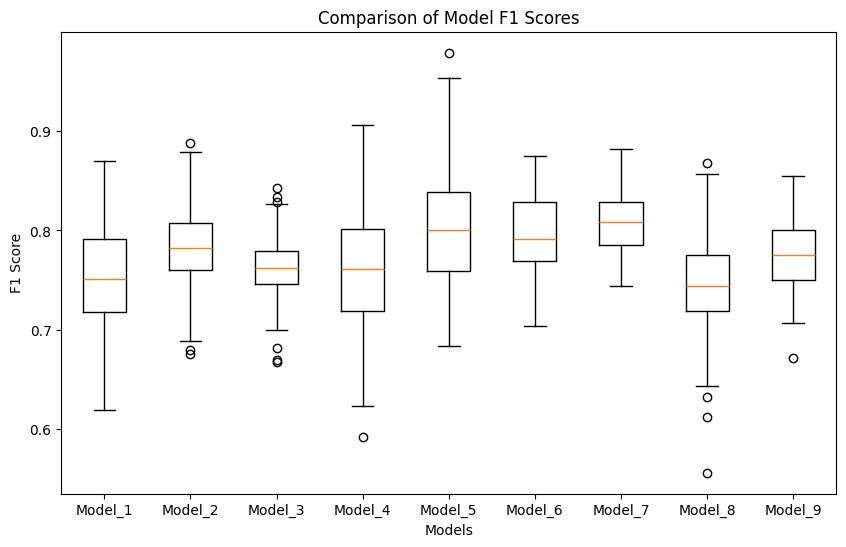

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 模拟数据
models = ['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_6', 'Model_7', 'Model_8', 'Model_9']
means = [0.75, 0.78, 0.77, 0.76, 0.80, 0.79, 0.81, 0.74, 0.77]  # 每个模型的F1均值
std_devs = [0.05, 0.04, 0.03, 0.06, 0.05, 0.04, 0.03, 0.05, 0.04]  # 每个模型的F1方差

# 生成模拟数据点
data = [np.random.normal(loc=mean, scale=std, size=100) for mean, std in zip(means, std_devs)]

# 绘制箱线图
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=models)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comparison of Model F1 Scores')
plt.show()